In [1]:
import pandas as pd, numpy as np
import os
import random

import matplotlib.pyplot as plt
import seaborn as sns 

from glob import glob
import cv2
from PIL import Image

In [2]:
df = pd.read_csv('/kaggle/input/rapid-cxr-dataset/metadata.csv')
tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','*', '*'))}    
    
df['path'] = df['Image Index'].map(tmp)

In [3]:
def LineAugmentation(image, n_lines=1, p=1.0, line_folder='/kaggle/input/xray-line-augmentation'):
    aug_prob = random.random()
    if aug_prob < p:
        height, width, _ = image.shape  # target image width and height
        line_images = [im for im in os.listdir(line_folder)]

        for _ in range(n_lines):
            # Randomly select and process a line image
            line = cv2.imread(os.path.join(line_folder, random.choice(line_images)))
            line = cv2.cvtColor(line, cv2.COLOR_BGR2RGB)
            line = cv2.flip(line, random.choice([-1, 0, 1]))  # Random flip
            line = cv2.rotate(line, random.choice([0, 1, 2]))  # Random rotation

            # Resize the line to match the target image dimensions
            line_resized = cv2.resize(line, (width, height), interpolation=cv2.INTER_AREA)

            # Convert line image to grayscale and create a binary mask
            img2gray = cv2.cvtColor(line_resized, cv2.COLOR_RGB2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Prepare the background and foreground for blending
            img_bg = cv2.bitwise_and(image, image, mask=mask_inv)
            line_fg = cv2.bitwise_and(line_resized, line_resized, mask=mask)

            # Blend the line with the original image
            dst = cv2.add(img_bg, line_fg)

            # Place the blended image back into the original image
            image = dst

    return image

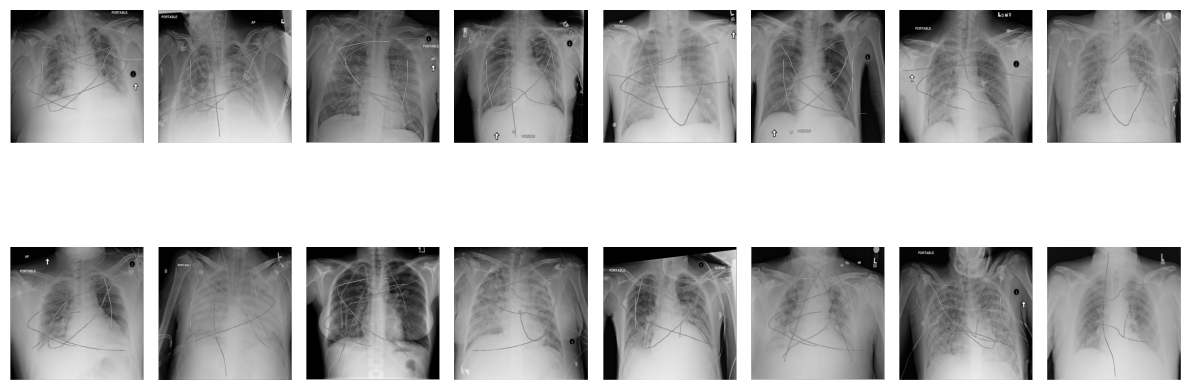

In [4]:
plt.figure(figsize=(12,6))

for i in range(16):
    plt.subplot(2,8,i+1)
    path = df.iloc[i]['path']
    img = cv2.imread(path)
    img = LineAugmentation(img, n_lines=5)
    
    plt.imshow(img)
    plt.axis('off')
    
plt.tight_layout()
plt.show()